In [1]:
# TIRF background
# https://www.microscopyu.com/techniques/fluorescence/total-internal-reflection-fluorescence-tirf-microscopy
# https://www.leica-microsystems.com/science-lab/life-science/total-internal-reflection-fluorescence-tirf-microscopy/
# Tables of fluorochromes https://www.bu.edu/flow-cytometry/files/2013/06/Fluorochromes-Brightness-Chart.pdf
# Tool to visualize colour of fluorochromes https://www.fpbase.org/spectra/
# To open nd2 files import nd2
# Images should be 1606 X 1606
#import nd2
import numpy as np
from skimage.feature import peak_local_max
from scipy import ndimage 
import matplotlib.pyplot as plt
import cv2
# path to data - you can set this as an environment variable
pathToData = "c:/users/omer/tirf/data"
import os, sys
sys.path.append(pathToData)
import nd2
#img = nd2.imread('c:/users/omer/tirf/data/set1/100xdiluted_10T_200msdelay_1_bsa_500ms.nd2')
from pims import ND2_Reader
frames = ND2_Reader('c:/users/omer/tirf/data/set1/100xdiluted_10T_200msdelay_1_bsa_500ms.nd2')
#frames[82]  # display frame 82
# 
#There is a green channel and a red channel (a filter splits the light to red and green and it's fed into 2 cameras)
#Each channel is the result of exciting using an appropriate laser
# The DNA is orange (so in the red channel) and green is negative control
# Each nanostructure can contain 10 or so tags (this corresponds to 10T in the file name)
# Currently we can detect 2 tags, and can probably do 4 by manually replacing the filter. To go higher we have to 



C:\Users\Omer\anaconda3\envs\tirf2\lib\site-packages\pims\api.py:111: UserWarning: 'ND2_Reader' has been renamed to 'ND2Reader_SDK' and will beremoved in future pims versions. Please use the new name, or try out the pure-Python one named `ND2Reader`.
  warn("'ND2_Reader' has been renamed to 'ND2Reader_SDK' and will be"
C:\Users\Omer\anaconda3\envs\tirf2\lib\site-packages\pims\base_frames.py:478: UserWarning: Please call FramesSequenceND.__init__() at the start of thethe reader initialization.
  warn("Please call FramesSequenceND.__init__() at the start of the"


Frame([[118, 126, 116, ..., 104, 112, 115],
       [121, 122, 125, ..., 122, 114, 114],
       [121, 124, 127, ..., 116, 112, 119],
       ...,
       [122, 131, 124, ..., 132, 118, 132],
       [123, 124, 128, ..., 128, 118, 120],
       [125, 125, 137, ..., 136, 117, 118]], dtype=uint16)
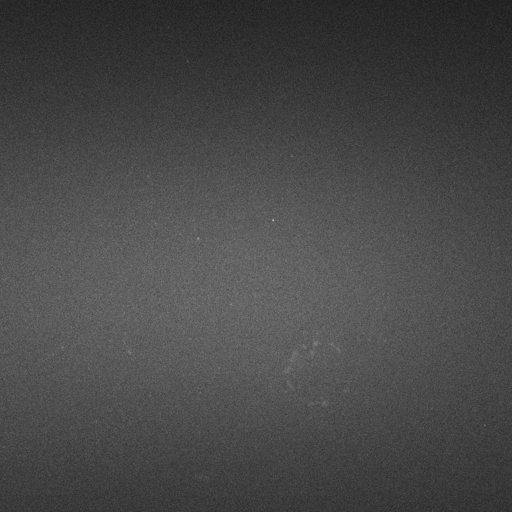

In [2]:
frames[1]

Text(0, 0.5, 'Frequency')

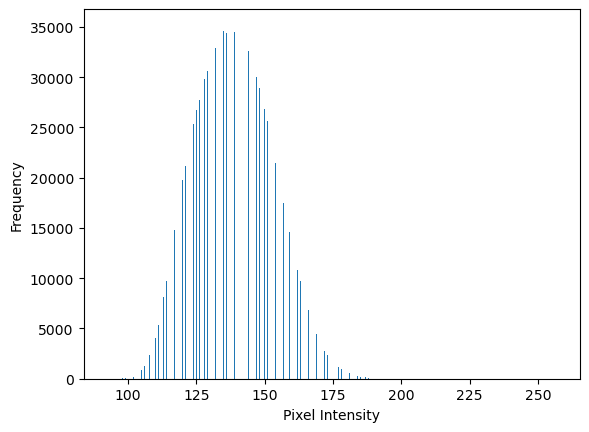

In [3]:
img = frames[1]
plt.hist(img.flatten(), bins = 1000)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

In [4]:
from skimage import morphology
from skimage import segmentation

In [6]:
#Normalize image - do we need it ?
minimumValue = 0
maximumValue = 1
normalizedImage =  cv2.normalize(img, None, minimumValue, maximumValue, cv2.NORM_MINMAX)

ModuleNotFoundError: No module named 'cv2'

In [4]:

#Otsu's Thresholding
def perform_otsu_threshlding(image):
    #image_norm = tools_read_images.normalize_image(image, max_val=255)
    a, image_thresh = cv2.threshold(image_norm.astype(np.uint8), 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return image_thresh

def perform_multi_otsu_threshlding(image, num_classes = 4, num_bins = 256):
    image_norm = tools_read_images.normalize_image(image, max_val=255)
    thresholds = skimage.filters.threshold_multiotsu(image_norm, classes=num_classes, nbins = num_bins)
    thresh = cv2.inRange(image_norm, thresholds[-1], 255)
    return thresh

def refine_thresholding(thresh, kernel_size_erode = 3, kernel_size_dilate = 5):
    kernel_erode = np.ones((kernel_size_erode, kernel_size_erode), np.uint8)
    kernel_dilate = np.ones((kernel_size_dilate, kernel_size_dilate), np.uint8)
    thresh_ref = cv2.erode(thresh, kernel_erode, iterations=1) 
    thresh_ref = cv2.dilate(thresh_ref, kernel_dilate, iterations=1) 
    thresh_ref = cv2.normalize(thresh_ref, None, 0, 1, cv2.NORM_MINMAX)
    return thresh_ref

# origamis
kse_struct_back = 5; ksd_struct_back = 13 #5,13
kse_struct_prot = 2; ksd_struct_prot = 2

thresh_struct_back = perform_otsu_threshlding(corr_img)
thresh_struct_back_ref = refine_thresholding(thresh_struct_back, 
                                                                    kernel_size_erode = kse_struct_back, 
                                                                    kernel_size_dilate = ksd_struct_back)
extracted_structure =  corr_img * thresh_struct_back_ref
plt.figure(figsize=(4,4))
plt.imshow(thresh_struct_back_ref,  cmap = 'gray')

# proteins
thresh_struct_prot = perform_multi_otsu_threshlding(extracted_structure)
thresh_struct_prot_ref = refine_thresholding(thresh_struct_prot, 
                                                                    kernel_size_erode = kse_struct_prot, 
                                                                    kernel_size_dilate = ksd_struct_prot)
extracted_proteins = extracted_structure * thresh_struct_prot_ref
plt.figure(figsize=(4,4))
plt.imshow(thresh_struct_prot_ref,  cmap = 'gray')